In [112]:
#from skimage import io
#from skimage import color
#from skimage.restoration import denoise_nl_means, estimate_sigma

import numpy as np
from numpy import ndarray
from numpy.fft import fft, fftfreq, ifft

#from scipy import ndimage as nd
#from scipy.fft import fft, ifft
#from scipy import fftpack

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time
import cv2
from math import sqrt
from math import exp

(3000, 4096, 3)

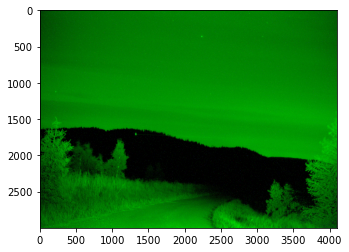

In [113]:
#img = cv2.imread("../dataset/honor/1.jpg")
img = cv2.imread("../dataset/4096-3000-max.png")
# img = img[1000:2000, 1200:2000]
#img = cv2.imread("../dataset/images/DSC_2757.JPG")
# img = cv2.resize(img, [1600, 1060])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

(3000, 4096)

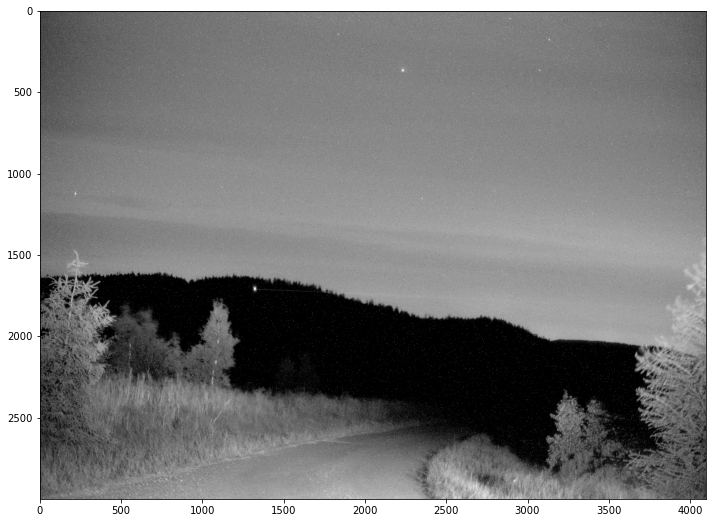

In [114]:
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = img[:, :, 1]
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(gray, cmap='gray')
fig.tight_layout()
fig.savefig("../files/rotations/1_gray.png")
gray.shape

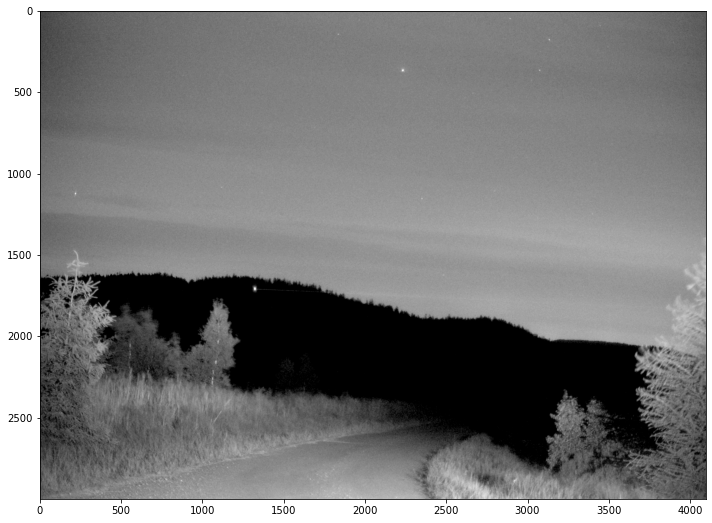

In [115]:
# Remove noise
blurred = cv2.medianBlur(gray, 5)
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(blurred, cmap='gray')
fig.tight_layout()
#cv2.imwrite('../files/blurred_image.png', blurred)
gray = blurred

In [116]:
#kernel: ndarray = np.ones((15,15),np.uint8)
#morphed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

#fig, ax = plt.subplots(figsize=(10,8))
#ax.imshow(morphed, cmap='gray')
#fig.tight_layout()


In [117]:
cols = np.sum(gray, axis=0)
cols.shape

(4096,)

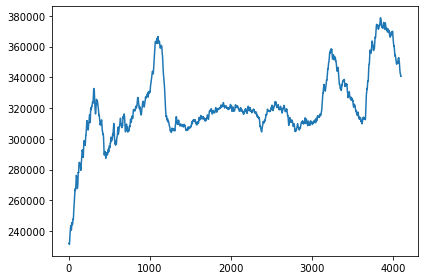

In [118]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(cols)
fig.tight_layout()
fig.savefig("../files/rotations/1_gray_cols.png")

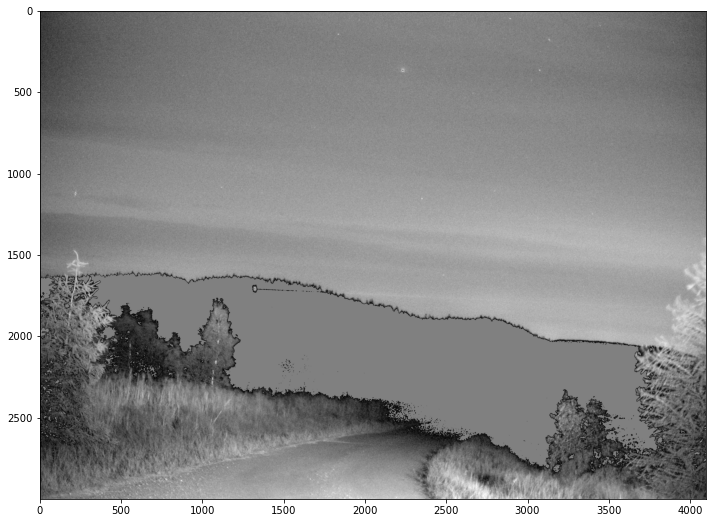

In [119]:
img_width = img.shape[1]
img_height = img.shape[0]

interval = 100
median = np.median(gray)
nobackgr = gray.copy()
nobackgr[nobackgr > median + interval] = median
nobackgr[nobackgr < median - interval] = median

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(nobackgr, cmap='gray')
fig.tight_layout()
fig.savefig("../files/rotations/1_removed_extremes.png")

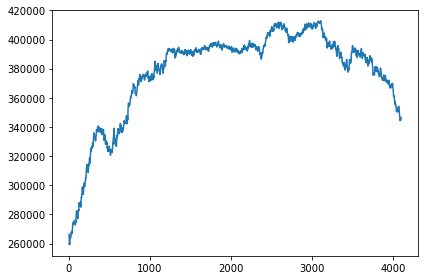

In [120]:
cols_nobackgr = np.sum(nobackgr, axis=0)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(cols_nobackgr)
fig.tight_layout()
fig.savefig("../files/rotations/1_removed_extremes_cols.png")

## Removal of extreme intensitites using local information

In [121]:
# low_percentile = np.percentile(nobackgr, 10)
# high_percentile = np.percentile(nobackgr, 90)
#
#
# cleaned = nobackgr.copy()
# median_of_img = np.median(nobackgr)
# box_size = 100
# for x in range(0, img_width, box_size):
#     for y in range(0, img_height, box_size):
#         cell = nobackgr[y:y+box_size, x:x+box_size]
#         lp_cell = np.percentile(cell, 5)
#         hp_cell = np.percentile(cell, 95)
#         if lp_cell <= low_percentile and hp_cell >= high_percentile:
#             cleaned[y:y+box_size, x:x+box_size] = median_of_img
#
# fig, ax = plt.subplots(figsize=(10,8))
# ax.imshow(cleaned, cmap='gray')
# fig.tight_layout()

## Removing high intensity regions using blob extraction

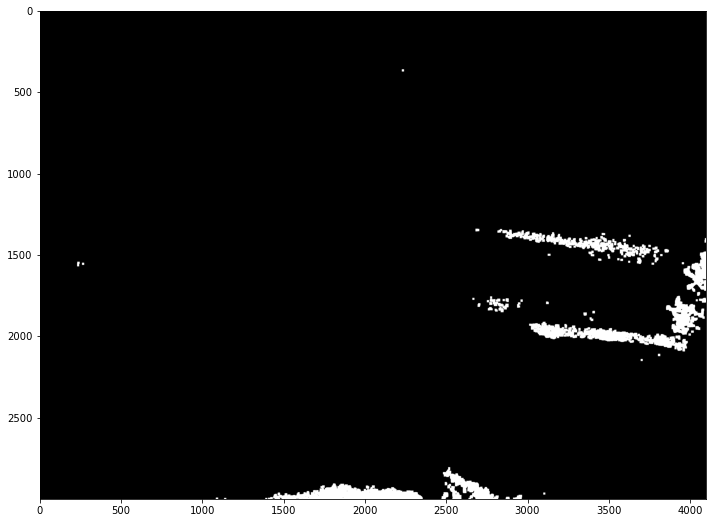

In [122]:
nobackgr = gray
hp = np.percentile(nobackgr, 95)
ret, thres = cv2.threshold(nobackgr, thresh=hp, maxval=255, type=cv2.THRESH_BINARY)
binary = cv2.morphologyEx(thres, cv2.MORPH_OPEN, np.ones((13,13),np.uint8))
#binary = cv2.morphologyEx(binary, cv2.MORPH_DILATE, np.ones((7,7),np.uint8))

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(binary, cmap='gray')
fig.tight_layout()

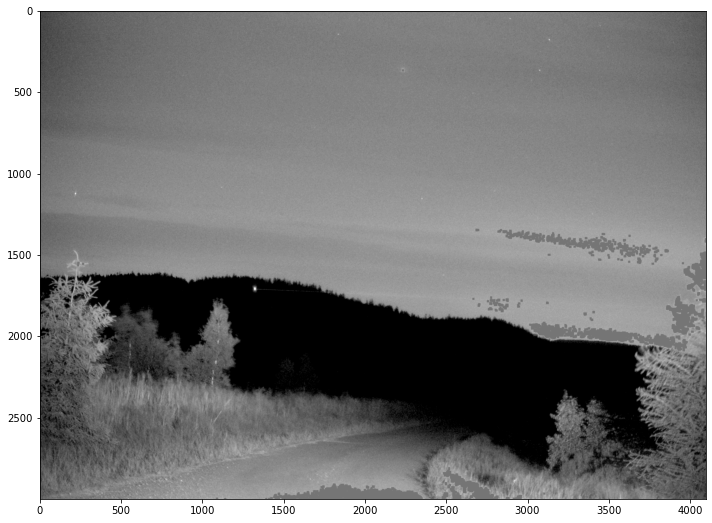

In [123]:
#nobackgr = gray
replacement_value = np.percentile(nobackgr, 40)
removed_blobs = nobackgr.copy()
removed_blobs[binary==255] = replacement_value

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(removed_blobs, cmap='gray')
fig.tight_layout()

## Padding

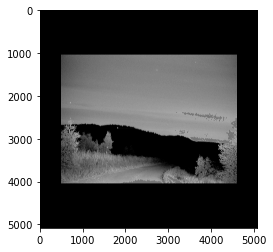

In [124]:
import math
# Pad the image before rotation, so that the whole image is visible
diagonal = math.ceil(math.sqrt(img_height ** 2 + img_width ** 2))
vertical_pad = diagonal - img_height
vertical_pad_half = vertical_pad // 2
horizontal_pad = diagonal - img_width
horizontal_pad_half = horizontal_pad // 2

padded = np.pad(removed_blobs, [[vertical_pad_half, vertical_pad_half],
                           [horizontal_pad_half, horizontal_pad_half]],
                'constant', constant_values=0)
plt.imshow(padded, cmap='gray')

## Rotation

Time it took to rotate [ms]:  169.27266120910645


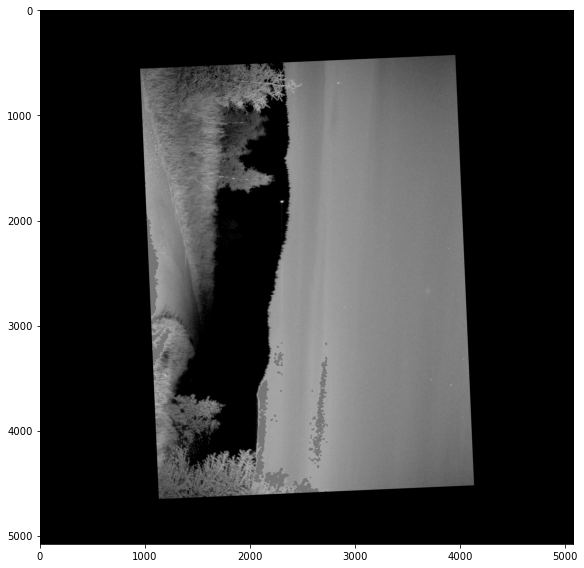

In [125]:
(h, w) = padded.shape[:2]
(cX, cY) = (w // 2, h // 2)
# 39.5
# DSC -78
# 56.5
rot_degrees = -87.5
M = cv2.getRotationMatrix2D((cX, cY), rot_degrees, 1.0)
start = time.time()
rotated = cv2.warpAffine(padded, M, (w, h))
print("Time it took to rotate [ms]: ", (time.time() - start) * 1000)
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(rotated, cmap='gray')
fig.tight_layout()
fig.savefig("../files/rotations/1_rotated.png")

/tmp/ipykernel_8172/3819918033.py:7: RuntimeWarning: invalid value encountered in true_divide
  cols_nobackgr /= nonzero_counts


array([0., 0., 0., ..., 0., 0., 0.])

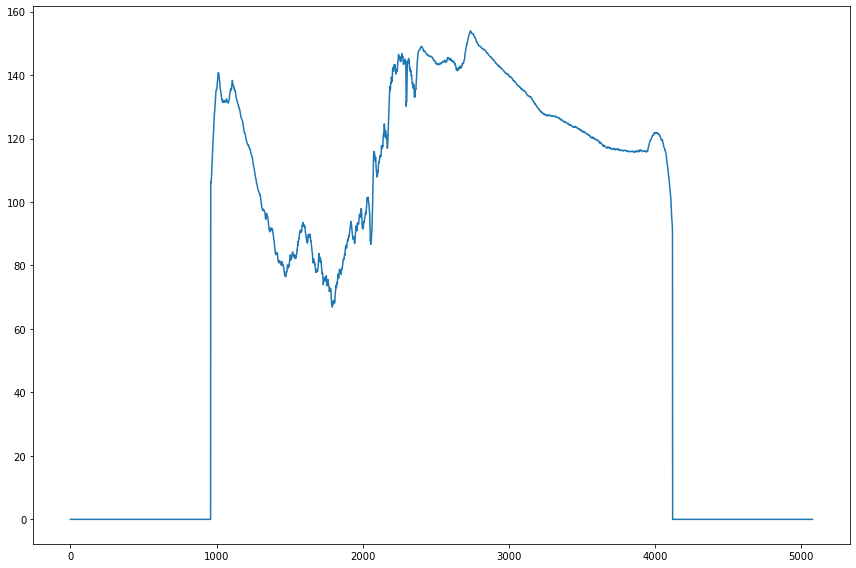

In [126]:
rotated_copy = rotated.copy()
rotated_copy = rotated_copy[:,:]
img_height = rotated_copy.shape[0]
cols_nobackgr = np.sum(rotated_copy, axis=0).astype(float)

nonzero_counts = np.count_nonzero(rotated_copy, axis=0)
cols_nobackgr /= nonzero_counts
cols_nobackgr[np.isnan(cols_nobackgr)] = 0

min_nonzero_counts = 200 # statistically significant
cols_nobackgr[nonzero_counts < min_nonzero_counts] = 0

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(cols_nobackgr)
fig.tight_layout()
fig.savefig("../files/rotations/1_rotated_cols.png")
cols_nobackgr

In [127]:
# rotated_copy = rotated.copy()
# rotated_copy[rotated_copy > 0] = 1
# plt.imshow(rotated_copy, cmap='gray')

In [128]:
def convolve(img, filter):
    #deriv_filter = np.array([1, 1, 1, -1, -1, -1])
    convolved = np.convolve(img, filter, mode='same')
    #clear = 200
    #convolved[:clear] = convolved[clear]
    #convolved[-clear:] = convolved[-clear]
    # convolved_abs = np.abs(convolved)
    convolved[convolved < 0] = 0
    return convolved



In [129]:
# # deriv_filter = np.array([-1, -1, -1,-1,-1, 0, 0, 0, 1, 1, 1, 1, 1])
# #deriv_filter = np.array([1, 1, 1, 1, 1, -2, -2, -2, 1, 1, 1, 1, 1], dtype=float)
# deriv_filter = np.array([-1, -1, -1, -1, -1, 2, 2, 2,2,2, -1, -1, -1, -1, -1], dtype=float)
# deriv_filter /= np.sum(np.abs(deriv_filter))
#
# convolved = convolve(cols_nobackgr, deriv_filter)
#
# col_index = np.argmax(convolved)
# print(col_index)
# fig, ax = plt.subplots(figsize=(6,4))
# ax.plot(convolved)
# fig.tight_layout()
# fig.savefig("../files/rotations/1_convolution_of_cols.png")

array([0., 0., 0., ..., 0., 0., 0.])

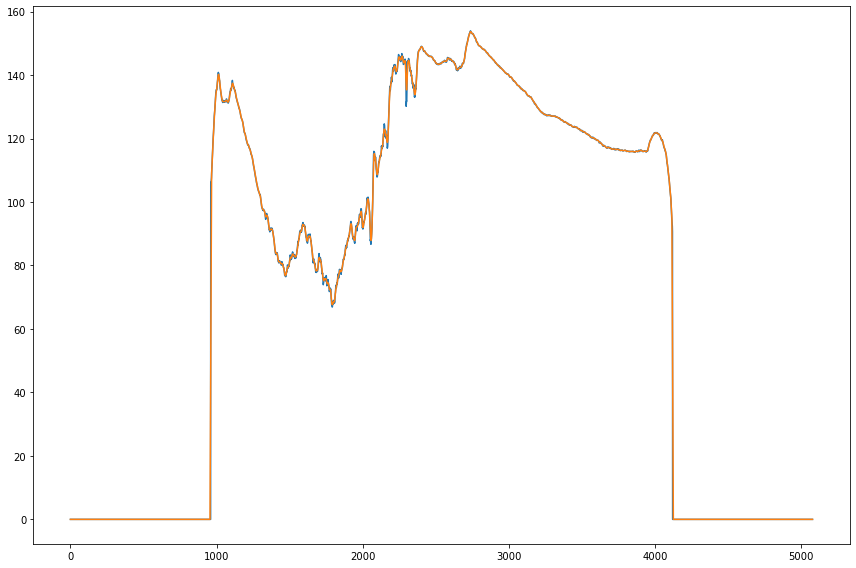

In [130]:
filter = np.ones([10], dtype=float)
filter /= np.sum(np.abs(filter))

convolved_average = convolve(cols_nobackgr, filter)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(cols_nobackgr[:])
ax.plot(convolved_average)
fig.tight_layout()
fig.savefig('../files/rotations/averaging_filter2.png')
convolved_average

## Computing slopes of the average

Over 6 pixels difference. Three to the left, three to the right.

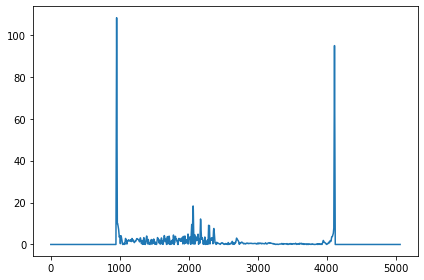

In [131]:
Y = convolved_average
slope_pixels = filter.shape[0] // 2

dY = np.roll(Y, -slope_pixels, axis=0) - np.roll(Y, slope_pixels, axis=0)
dY = dY[slope_pixels:-slope_pixels]

slopes = np.abs(dY)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(slopes)
fig.tight_layout()
fig.savefig("../files/rotations/slopes.png")

960

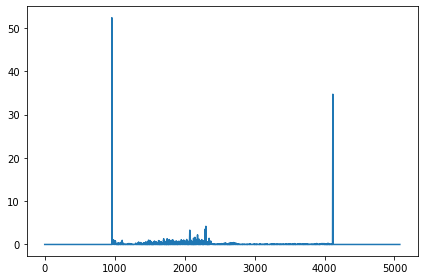

In [132]:
d = (cols_nobackgr - convolved_average)
d[d < 0] = 0
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(d)
fig.tight_layout()
fig.savefig("../files/rotations/signal_dif.png")
np.argmax(d)

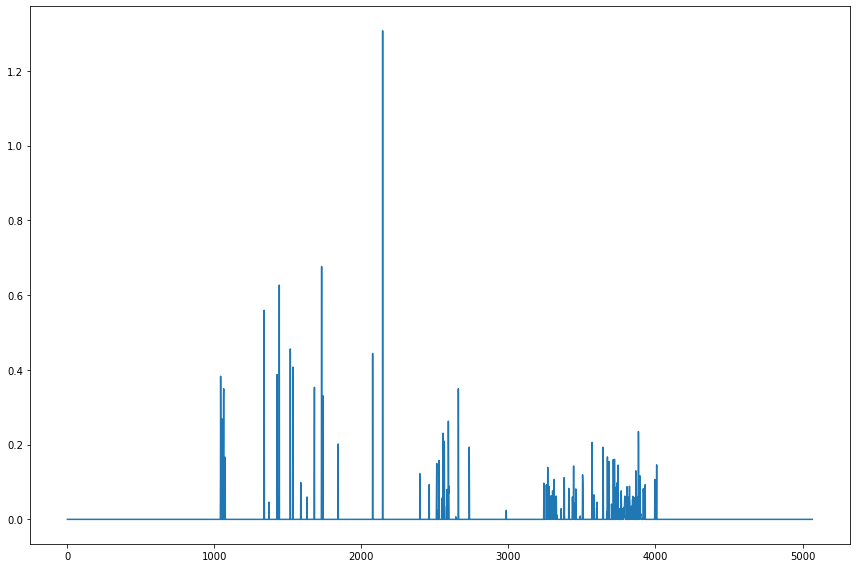

In [133]:
# Look at peaks only at local maxima and minima
thres = slopes < 0.2

d_div_slopes = d[slope_pixels:-slope_pixels] * thres

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(d_div_slopes)
fig.tight_layout()
fig.savefig("../files/rotations/filtered_slopes.png")

Remove values created by convolution of zeros.
Sequentilly, this would be rewriting values in a distance from zeros
reachable by the filter used previously for convolution.

In [134]:
# # First two lines are parametrizable.
# filter_of_previous_length = np.ones([filter.shape[0]])
# cols_copy = d.copy()
# mask_where_zeros = (cols_nobackgr == 0).astype(int)
# convolved_mask = convolve(mask_where_zeros, filter_of_previous_length)
# cols_copy[convolved_mask > 0] = 0
#
# fig, ax = plt.subplots(figsize=(6,4))
# ax.plot(cols_copy)
# fig.tight_layout()
# np.argmax(cols_copy)

In [135]:
# plt.hist(cols_copy[cols_copy > 0],bins=50)

In [136]:
# # Values that are significantly distant from others
# # 10 % distance from max value, if contains max K values
# vals = d_div_slopes[d_div_slopes > 0]
# min = np.min(vals)
# max = np.max(vals)
# interval = max - min
# candidates = vals[vals > 0.85 * interval]
# candidates

In [137]:
# mean = np.mean(vals)
# max / mean
#

In [138]:
# med = np.median(vals)
# max / med

